In [542]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
import re
import xgboost as xgb
from sklearn.metrics import precision_score
import os
import gzip
import random
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [4]:
#Returns a string of length bytes long
def dataloader(filepath, length):
    f = gzip.GzipFile(fileobj=open(filepath, 'rb'))
    data = f.read(length)
    return data.decode("utf-8")

In [744]:
#Returns dataframe of # of files long. Analyze the first length bytes of each file
def trainloader(direclist, filetype, length):
    fileid = np.arange(len(filetype))
    dat = []
    filelabels = []
    c = -1
    for direc in direclist:
        c+=1
        for file in os.listdir(direc):
            if file.endswith('.gz'):
                tempdat = dataloader(os.path.join(direc,file),length)
                dat = dat + [tempdat]
                filelabels.append(fileid[c])
            if file.endswith('fastq.truncated'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("utf-8")
                dat = dat + [tempdat]
                filelabels.append(fileid[c])
            if file.endswith('sra.truncated'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("ISO-8859-1")
                dat = dat + [tempdat]
                filelabels.append(fileid[c])
    data = {'Data': dat,
        'Type': filelabels
    }
    df = pd.DataFrame(data, columns = ['Data', 'Type'])
    return(df)

In [163]:
def rowextraction(predicted, truth):
    return(np.where(predicted==truth)[0])

In [209]:
def uncertainty(pred, row_ind, num_classes):
    class_arr = [[] for i in range(num_classes)]
    dist_arr = []
    for ind in row_ind:
        class_ind = np.argmax(pred[ind])
        class_arr[class_ind].append(np.max(pred[ind]))
    for arr in class_arr:
        dist_arr.append([np.mean(arr),np.std(arr)])
    return(dist_arr)

In [7]:
def FeatureImportance(model, features, importance):
    for im in importance:
        feature_important = model.get_score(importance_type = im)
        keys = list(feature_important.keys())
        feature_chars = []
        keylist = []
        for key in keys:
            keylist.append(int(key.replace('f','')))
        for i in keylist:
            feature_chars.append(features[i])
        values = list(feature_important.values())
        fdata = pd.DataFrame(data=values, index=feature_chars, columns=["score"]).sort_values(by = "score", ascending=False)
        fdata.plot(kind='barh', title = im)    
        
    

In [238]:
def confusionmatrix(truth, pred, names):
    cm = confusion_matrix(truth, pred)
    plt.figure()
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

In [220]:
def classaccuracy(truth, pred, ind, num_classes):
    classes = np.arange(num_classes)
    predcl = np.asarray([np.argmax(pred[i]) for i in ind])
    acc = []
    for cl in classes:
        truth_len = len(np.where(truth == cl)[0])
        pred_len = len(np.where(predcl == cl)[0])
        acc.append(pred_len/truth_len)
    return(acc)

In [587]:
def trainselector(train_data, train_label, n_class, split):
    labelmat = [[] for i in range(n_class)]
    splitnum = []
    datmat = []
    
    total_len = len(train_data)
    for s in split:
        nchoice = int(total_len*s)
        splitnum.append(nchoice)
    
    for c in range(n_class):
        t_labelloc = np.where(train_label == c)[0]
        #print(t_labelloc)
        #print(len(train_data[t_labelloc]))
        labelmat[c].extend(train_data[t_labelloc])
   
    for n in range(len(splitnum)):
        datmat.extend(np.random.choice(labelmat[n],splitnum[n]))
    
    
    return(datmat)
        

In [607]:
def FileClassifier(Dataset, ttsplit, filetype, fit_split, ngram_range, max_features, param, num_round, load):
    
    X = Dataset.iloc[:,0]
    y = Dataset.iloc[:,1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ttsplit, random_state = 42)
    fitset = trainselector(np.array(X_train), np.array(y_train), len(filetype), fit_split)
    
    if load == False:
        print("Generating Character Vectorizer...")
        TfidfVectorizer.partial_fit = partial_fit
        char_vectorizer = TfidfVectorizer(analyzer = 'char',
            ngram_range = ngram_range, max_features = max_features)
        char_vectorizer.fit(fitset)
        print(char_vectorizer.vocabulary_)
        print(char_vectorizer.get_feature_names())
        char_vectorizer2 = TfidfVectorizer(analyzer = 'char',
            ngram_range = ngram_range, max_features = max_features,
                                vocabulary = char_vectorizer.vocabulary_)
        char_vectorizer2.fit(X_train)
        print(char_vectorizer2.vocabulary_)
        print(char_vectorizer2.get_feature_names())
        train_chars = char_vectorizer2.transform(X_train)
        test_chars = char_vectorizer2.transform(X_test)
        pickle.dump(char_vectorizer, open("tfidfcv.pkl", "wb"))
        print("Character Vectorizer Saved")
        
    if load == True:
        print("Loading Character Vectorizer...")
        char_vectorizer = pickle.load(open("tfidfcv.pkl", 'rb'))
        print("Character Vectorizer Loaded")
        print(char_vectorizer.vocabulary_)
        print(char_vectorizer.get_feature_names())
        train_chars = char_vectorizer.transform(X_train)
        test_chars = char_vectorizer.transform(X_test)

    dtrain = xgb.DMatrix(train_chars, label = y_train)
    dtest = xgb.DMatrix(test_chars, label = y_test)
    
    if load == False:
        print("Training Model...")
        model = xgb.train(param, dtrain, num_round)
        pickle.dump(model, open("xgb_class.pkl", "wb"))
        print("Model Saved")
    if load == True:
        print("Loading Model...")
        model = pickle.load(open("xgb_class.pkl", "rb"))
        print("Model Loaded")
        
    FeatureImportance(model, char_vectorizer.get_feature_names(), ['weight','cover','gain'])
    
    
    preds = model.predict(dtest)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    print("Precision: {}".format(precision_score(y_test, best_preds, average='macro')))
    y_test_arr = np.asarray(y_test).reshape(1,-1).squeeze()
    correct_rows = rowextraction(best_preds,y_test_arr)
    class_acc = classaccuracy(y_test_arr, preds, correct_rows, param['num_class'])
    pred_uncertainty = uncertainty(preds, correct_rows, param['num_class'])
    for i in range(param['num_class']):
        print("Class {}".format(filetype[i]) + " mean and sd: {}".format(pred_uncertainty[i])
             + ", Accuracy: {}".format(round(class_acc[i],2)))
    confusionmatrix(y_test_arr, best_preds, filetype)
    
    
    
    return(model)

In [745]:
dirs = ['/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.fna',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.gbff',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.gff',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/FASTQ_truncated',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/SRA_truncated'
       ]
filetype = ['fna', 'gbff', 'gff', 'fastq', 'sra']
data_iterable = trainloader(dirs, filetype, 3000)

In [742]:
param = {
    'max_depth': 10,  # the maximum depth of each tree
    'eta': 0.1,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': len(filetype)}  # the number of classes that exist in this datset
num_round = 40 
ngram_range = (4,8)
max_features = 60
fit_split = [0.21, 0.31, 0.34, 0.12, 0.02]
Dataset = data_iterable
ttsplit = 0.25
load = True

Loading Character Vectorizer...
Character Vectorizer Loaded
{'aaga': 14, 'agaa': 18, 'gaag': 32, 'gaaa': 31, 'aaac': 10, 'caaa': 21, 'aaaa': 9, 'aaat': 12, 'tgaa': 53, 'aatt': 16, 'attt': 20, 'tttt': 59, 'ttta': 57, 'ttat': 55, 'tatt': 50, 'atta': 19, 'ttaa': 54, 'acaa': 17, 'aaag': 11, 'aagc': 15, 'ttga': 56, 'tttc': 58, 'tcaa': 51, 'cttt': 22, 'taaa': 49, 'aaca': 13, 'gggg': 34, 'ggggg': 35, 'gggggg': 36, 'prot': 42, 'rote': 46, 'otei': 40, 'tein': 52, 'gene': 33, 'prote': 43, 'rotei': 47, 'otein': 41, 'protei': 44, 'rotein': 48, 'protein': 45, 'ggggggg': 37, 'ion ': 39, '\tgen': 3, 'ffff': 26, 'fffff': 27, 'ffffff': 28, 'fffffff': 29, 'gggggggg': 38, 'ffffffff': 30, 'eeee': 23, 'eeeee': 24, 'eeeeee': 25, '????': 4, '?????': 5, '??????': 6, '???????': 7, '????????': 8, '\x00\x00\x00\x00': 0, '\x00\x00\x00\x00\x00': 1, '\x00\x00\x00\x00\x00\x00': 2}
['\x00\x00\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00', '\tgen', '????', '?????', '??????', '???????', '????????', 'aaaa

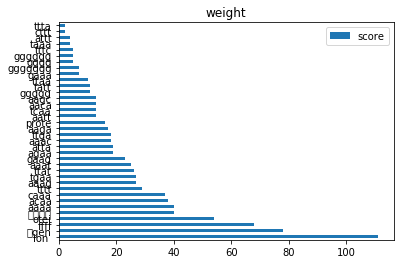

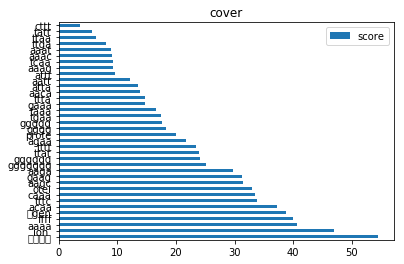

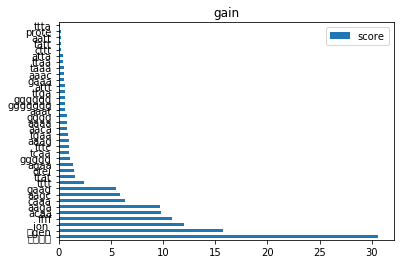

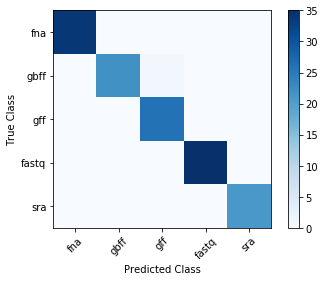

In [743]:
xgbmodel = FileClassifier(Dataset, ttsplit, filetype, fit_split, ngram_range, max_features, param, num_round, load)